# Predictive Analysis: Weather and ERCOT Prices

![Power Lines](https://www.fae-group.com/images/applicazioni/header/Applications_power_lines_fae.jpg)

The data for this analysis comes from:
- [Weather](http://mrcc.isws.illinois.edu/) - Midwestern Regional Climate Center: MRCC
- [Day Ahead Pricing](http://mis.ercot.com/misapp/GetReports.do?reportTypeId=13060&reportTitle=Historical%20DAM%20Load%20Zone%20and%20Hub%20Prices&showHTMLView=&mimicKey) - ERCOT Market Prices
- [RTM Pricing](http://mis.ercot.com/misapp/GetReports.do?reportTypeId=13061&reportTitle=Historical%20RTM%20Load%20Zone%20and%20Hub%20Prices&showHTMLView=&mimicKey) - ERCOT Market Prices

## Question
1. Is there a correlation between weather and electricty pricing.
2. Is the correlation stronger between Spot Pricing or Day ahead pricing?
3. Can the correlation be used with a neural network to generate price prediction?
4. If not, can the correlation be used to generate a pricing direction signal?

## Methodology
1. Download data from source sites
2. Convert to CSV using VBA in excel
3. Aggregate CSV files to single data frame for:
  - Spot Pricing
  - DA Pricing
  - Weather
4. Clean data and create calculated features
5. Create Neural Net in Tensorflow
6. Train and analyze
7. Setup trained model as a webservice
8. Feed forecast data to model to generate price predictions

![Heat Map of Texas](http://www.ercot.com/content/wcm/landing_pages/88828/Weather_Map.png)

### Import Components and Data

In [1]:
# import packages
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import numpy as np

# Data ingestion done in separate python scripts
import load_spot_pricing_data as sp_pricing
import load_day_ahead_pricing_data as da_pricing
import load_weather_data as weather

Spot Prices Loaded
DA Prices Loaded
Weather loaded


In [2]:
# Spot Pricing DataFrame
sp_houston_2013 = sp_pricing.frame_2013[sp_pricing.frame_2013['Settlement Point Name'] == 'HB_HOUSTON'].copy()
sp_houston_2013 = sp_houston_2013[sp_houston_2013['Delivery Interval'] <= 1]
sp_houston_2013 = sp_houston_2013.sort_values(by=['Delivery Date', 'Delivery Hour']).reset_index(drop=True)
sp_houston_2013['Hour Number'] = sp_houston_2013.index
sp_houston_2013['Settlement Point Price'] = pd.to_numeric(sp_houston_2013['Settlement Point Price'], errors='coerce')
sp_houston_2013['SPP 10 DMA'] = sp_houston_2013['Settlement Point Price'].rolling(window=240).mean()
sp_houston_2013['SPP 10 Mean Dev'] = sp_houston_2013['Settlement Point Price'] - sp_houston_2013['SPP 10 DMA']

# Day Ahead Pricing DataFrame
da_houston_2013 = da_pricing.frame_2013[da_pricing.frame_2013['Settlement Point'] == 'HB_HOUSTON'].copy()
da_houston_2013 = da_houston_2013.sort_values(by=['Delivery Date', 'Hour Ending']).reset_index(drop=True)
da_houston_2013['Hour Number'] = da_houston_2013.index
da_houston_2013['Settlement Point Price'] = pd.to_numeric(da_houston_2013['Settlement Point Price'], errors='coerce')
da_houston_2013['SPP 10 DMA'] = da_houston_2013['Settlement Point Price'].rolling(window=240).mean()
da_houston_2013['SPP 10 Mean Dev'] = da_houston_2013['Settlement Point Price'] - da_houston_2013['SPP 10 DMA']
da_houston_2013['SPP 30 DMA'] = da_houston_2013['Settlement Point Price'].rolling(window=720).mean()
da_houston_2013['SPP 30 Mean Dev'] = da_houston_2013['Settlement Point Price'] - da_houston_2013['SPP 30 DMA']

# Weather DataFrame
weather_2013 = weather.weather_df[weather.weather_df['Date'] < datetime.date(2014, 1, 1)]
weather_2013 = weather_2013.sort_values(by=['Date']).reset_index(drop=True)
weather_2013 = weather_2013.select_dtypes(['float', 'int'])
weather_2013 = weather_2013.drop(['PeakWindGust', 'LowCloudHt', 'MedCloudHt', 'HighCloudHt', 'Visibility', 'WindDirection', 'SeaLevPress', 'Precip'], axis=1)
weather_2013 = weather_2013.fillna(method='bfill')
weather_2013['Temp 10 DMA'] = weather_2013['Temp'].rolling(window=240).mean()
weather_2013['Temp 10 Mean Dev'] = weather_2013['Temp'] - weather_2013['Temp 10 DMA']
weather_2013['Temp 30 DMA'] = weather_2013['Temp'].rolling(window=720).mean()
weather_2013['Temp 30 Mean Dev'] = weather_2013['Temp'] - weather_2013['Temp 30 DMA']
weather_2013['AtmPress 10 DMA'] = weather_2013['AtmPress'].rolling(window=240).mean()
weather_2013['AtmPress 10 Mean Dev'] = weather_2013['AtmPress'] - weather_2013['AtmPress 10 DMA']
weather_2013['AtmPress 30 DMA'] = weather_2013['AtmPress'].rolling(window=720).mean()
weather_2013['AtmPress 30 Mean Dev'] = weather_2013['AtmPress'] - weather_2013['AtmPress 30 DMA']

### Data Features

In [3]:
sp_joined_2013_stats = weather_2013[['Temp',
                                     'Temp 10 DMA',
                                     'Temp 10 Mean Dev',
                                     'AtmPress 10 Mean Dev']].join(sp_houston_2013[['Settlement Point Price', 'SPP 10 DMA', 'SPP 10 Mean Dev']])

In [4]:
print(sp_joined_2013_stats.loc[3600:5600, ['Temp 10 Mean Dev',
                                           'Temp 10 DMA',
                                           'AtmPress 10 Mean Dev',
                                           'SPP 10 Mean Dev', 
                                           'Settlement Point Price']].corr()['Settlement Point Price'])

Temp 10 Mean Dev         -0.129637
Temp 10 DMA               0.004886
AtmPress 10 Mean Dev      0.051050
SPP 10 Mean Dev           0.996870
Settlement Point Price    1.000000
Name: Settlement Point Price, dtype: float64


**While there is some correlation between the 'Settlement Point Price' and the other data fields. This does not look like it is storng enough to make any predictions.**

In [5]:
da_joined_2013 = weather_2013[['Temp',
                               'AtmPress',
                               'Temp 10 DMA',
                               'Temp 30 DMA',
                               'AtmPress 10 DMA',
                               'AtmPress 30 DMA',
                               'Temp 10 Mean Dev',
                               'Temp 30 Mean Dev',
                               'AtmPress 10 Mean Dev',
                               'AtmPress 30 Mean Dev']].join(da_houston_2013[['Settlement Point Price', 'SPP 10 DMA', 'SPP 30 DMA']])

In [6]:
da_joined_2013 = da_joined_2013.dropna(axis=0, how='any')

In [7]:
print(da_joined_2013.loc[:, ['AtmPress',
                             'Temp',
                             'AtmPress 10 DMA',
                             'AtmPress 30 DMA',
                             'AtmPress 10 Mean Dev',
                             'AtmPress 30 Mean Dev',
                             'SPP 10 DMA',
                             'SPP 30 DMA',
                             'Temp 10 DMA',
                             'Temp 30 DMA',
                             'Temp 10 Mean Dev',
                             'Temp 30 Mean Dev',
                             'Settlement Point Price']].corr()['Settlement Point Price'])

AtmPress                  0.004510
Temp                      0.006959
AtmPress 10 DMA          -0.103630
AtmPress 30 DMA          -0.110947
AtmPress 10 Mean Dev      0.066078
AtmPress 30 Mean Dev      0.059089
SPP 10 DMA                0.199304
SPP 30 DMA                0.175954
Temp 10 DMA               0.131099
Temp 30 DMA               0.124329
Temp 10 Mean Dev         -0.151632
Temp 30 Mean Dev         -0.130726
Settlement Point Price    1.000000
Name: Settlement Point Price, dtype: float64


In [8]:
# Min-Max Normalize Joined DataFrame
# da_joined_2013 = da_joined_2013[np.abs(da_joined_2013['Settlement Point Price']-da_joined_2013['Settlement Point Price'].mean())<=(2*da_joined_2013['Settlement Point Price'].std())]
da_joined_2013 = (da_joined_2013-da_joined_2013.min())/(da_joined_2013.max()-da_joined_2013.min())
da_joined_2013['Settlement Point Price'] = da_joined_2013.applymap(lambda x: np.log(x+1))

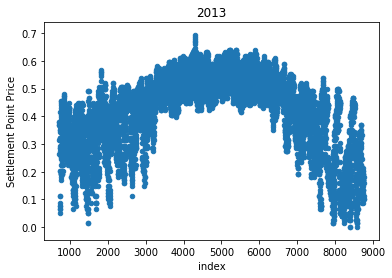

In [9]:
da_joined_2013.reset_index().plot.scatter(x='index', y='Settlement Point Price', title='2013')

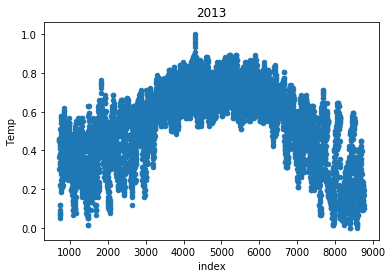

In [10]:
da_joined_2013.reset_index().plot.scatter(x='index', y='Temp', title='2013')

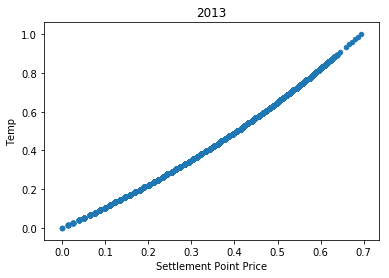

In [11]:
da_joined_2013.reset_index().plot.scatter(x='Settlement Point Price', y='Temp', title='2013')

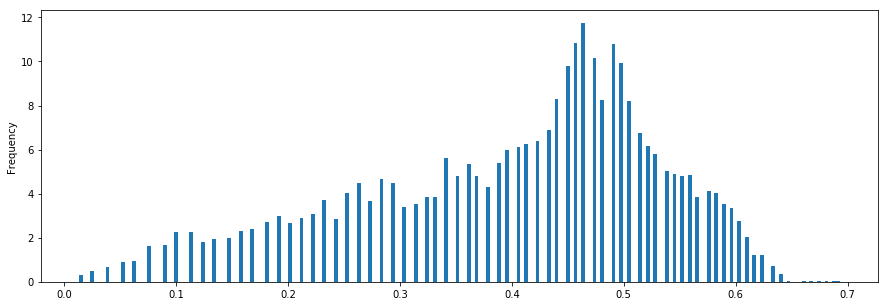

In [104]:
da_joined_2013[da_joined_2013["Settlement Point Price"] > 0]["Settlement Point Price"].plot.hist(bins=200, figsize=[15,5], density=True)

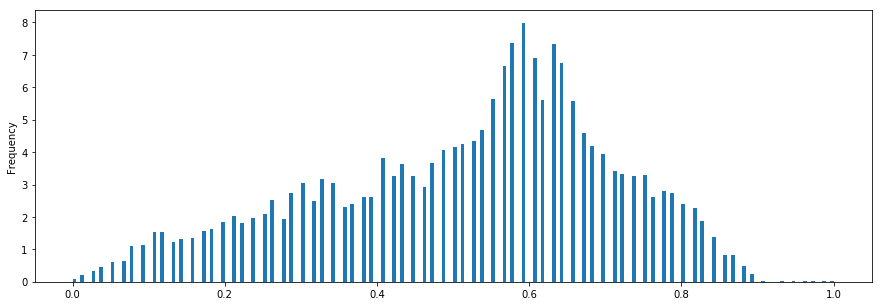

In [105]:
da_joined_2013["Temp"].plot.hist(bins=200, figsize=[15,5], density=True)

In [106]:
print(da_joined_2013.loc[:, ['AtmPress',
                             'Temp',
                             'AtmPress 10 DMA',
                             'AtmPress 30 DMA',
                             'AtmPress 10 Mean Dev',
                             'AtmPress 30 Mean Dev',
                             'SPP 10 DMA',
                             'SPP 30 DMA',
                             'Temp 10 DMA',
                             'Temp 30 DMA',
                             'Temp 10 Mean Dev',
                             'Temp 30 Mean Dev',
                             'Settlement Point Price']].corr()['Settlement Point Price'])

AtmPress                 -0.606635
Temp                      0.997068
AtmPress 10 DMA          -0.500653
AtmPress 30 DMA          -0.657020
AtmPress 10 Mean Dev     -0.357549
AtmPress 30 Mean Dev     -0.350662
SPP 10 DMA                0.366121
SPP 30 DMA                0.490284
Temp 10 DMA               0.764309
Temp 30 DMA               0.742713
Temp 10 Mean Dev          0.627643
Temp 30 Mean Dev          0.672482
Settlement Point Price    1.000000
Name: Settlement Point Price, dtype: float64


In [107]:
da_houston_2013[da_houston_2013["Settlement Point Price"] > 0].select_dtypes(include=np.number).idxmin(axis=0, skipna=True)

Settlement Point Price     674
Hour Number                  0
SPP 10 DMA                 971
SPP 10 Mean Dev           6746
SPP 30 DMA                1337
SPP 30 Mean Dev           6961
dtype: int64

In [108]:
da_houston_2013[da_houston_2013["Settlement Point Price"] > 0].min()

Delivery Date             01/01/2013
Hour Ending                    01:00
Repeated Hour Flag                 N
Settlement Point          HB_HOUSTON
Settlement Point Price            12
Hour Number                        0
SPP 10 DMA                   24.2067
SPP 10 Mean Dev             -23.7334
SPP 30 DMA                   24.6621
SPP 30 Mean Dev             -23.1879
dtype: object

In [109]:
da_houston_2013[da_houston_2013["Settlement Point Price"] > 0 ].max()

Delivery Date             12/31/2013
Hour Ending                    24:00
Repeated Hour Flag                 Y
Settlement Point          HB_HOUSTON
Settlement Point Price        521.12
Hour Number                     8759
SPP 10 DMA                   43.1315
SPP 10 Mean Dev              480.824
SPP 30 DMA                   37.4056
SPP 30 Mean Dev              484.576
dtype: object

### Prepping Data for training

In [167]:
import keras
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [190]:
# Take a random sample for testing
sample = np.random.choice(da_joined_2013.index, size=int(len(da_joined_2013)*0.9), replace=False)
train_data = da_joined_2013.loc[sample]
test_data = da_joined_2013.drop(sample)
features = np.array(train_data.drop('Settlement Point Price', axis=1))
targets = np.array(train_data['Settlement Point Price'])
features_test =  np.array(test_data.drop('Settlement Point Price', axis=1))
targets_test = np.array(test_data['Settlement Point Price'])

print(features[:10])
print(targets[:10])

[[ 0.72368421  0.3042328   0.81286996  0.88443425  0.02954677  0.02590329
   0.60582083  0.57014115  0.52316357  0.4595774   0.52642031  0.84858244]
 [ 0.77631579  0.42857143  0.97832729  0.97604959  0.27837177  0.26270956
   0.5526352   0.58427939  0.54678319  0.52758968  0.81796405  0.91902381]
 [ 0.57894737  0.5         0.69390873  0.78227267  0.32267817  0.02143981
   0.5099078   0.44416095  0.59841334  0.65990495  0.76013219  0.95178027]
 [ 0.63157895  0.36772487  0.94834829  0.99979874  0.29923316  0.16333293
   0.39259667  0.38507994  0.48018794  0.49022761  0.58536183  0.99313155]
 [ 0.59210526  0.41269841  0.41244988  0.28825021  0.5055383   0.63130182
   0.72925554  0.74829709  0.44385169  0.42034573  0.45598156  0.45312137]
 [ 0.32894737  0.68783069  0.30198587  0.20854969  0.25882967  0.44445621
   0.4786019   0.45757356  0.80377787  0.74651226  0.14576086  0.05702272]
 [ 0.51315789  0.23280423  0.47746802  0.26578916  0.49674298  0.45504751
   0.58332187  0.66023735  0.274

#### Train and evaluate with simple MSE manual validation

In [191]:
##define base model
model = Sequential()
model.add(Dense(32, input_shape=[features.shape[1]], kernel_initializer='normal', activation='sigmoid'))
model.add(Dense(1, kernel_initializer='normal', activation="linear"))
sgd=keras.optimizers.SGD(lr=0.01)
model.compile(optimizer=sgd ,loss='mse',metrics=['mse'])

# Train Model
model.fit(features,targets, validation_data=[features_test, targets_test], batch_size=1, epochs=5, shuffle=False, verbose=1)

Train on 7235 samples, validate on 804 samples
Epoch 1/5
7235/7235 [==============================] - 24s 3ms/step - loss: 0.0120 - mean_squared_error: 0.0120 - val_loss: 0.0046 - val_mean_squared_error: 0.0046
Epoch 2/5
7235/7235 [==============================] - 26s 4ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 9.7011e-04 - val_mean_squared_error: 9.7011e-04
Epoch 3/5
7235/7235 [==============================] - 23s 3ms/step - loss: 6.0600e-04 - mean_squared_error: 6.0600e-04 - val_loss: 4.3393e-04 - val_mean_squared_error: 4.3393e-04
Epoch 4/5
7235/7235 [==============================] - 25s 3ms/step - loss: 3.1024e-04 - mean_squared_error: 3.1024e-04 - val_loss: 2.5449e-04 - val_mean_squared_error: 2.5449e-04
Epoch 5/5
7235/7235 [==============================] - 23s 3ms/step - loss: 1.8925e-04 - mean_squared_error: 1.8925e-04 - val_loss: 1.7021e-04 - val_mean_squared_error: 1.7021e-04


In [193]:
model.predict(features[2].reshape(-1,12))

array([[ 0.45256519]], dtype=float32)

#### Train and evaluate with Manual k-Fold Cross Validation

In [176]:
# define base model
def baseline_model():
    ##define base model
    model = Sequential()
    model.add(Dense(32, input_shape=[features.shape[1]], kernel_initializer='normal', activation='linear'))
    model.add(Dense(1, kernel_initializer='normal', activation="linear"))
    sgd=keras.optimizers.SGD(lr=0.01)
    model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['mse'])
    return model

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# evaluate model with standardized dataset
estimator = KerasRegressor(build_fn=baseline_model, nb_epoch=100, batch_size=5, verbose=1)

kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(estimator, features, targets, cv=kfold)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Epoch 1/1
724/724 [==============================] - 1s 1ms/step
Epoch 1/1
724/724 [==============================] - 1s 2ms/step
Epoch 1/1
724/724 [==============================] - 1s 1ms/step
Epoch 1/1


Exception ignored in: <bound method ScopedTFStatus.__del__ of <tensorflow.python.framework.c_api_util.ScopedTFStatus object at 0x000001546F795898>>
Traceback (most recent call last):
  File "c:\python\.virtualenv\ercot\lib\site-packages\tensorflow\python\framework\c_api_util.py", line 36, in __del__
    c_api.TF_DeleteStatus(self.status)
AttributeError: 'ScopedTFStatus' object has no attribute 'status'


724/724 [==============================] - 1s 1ms/step
Epoch 1/1
724/724 [==============================] - 1s 2ms/step
Epoch 1/1
723/723 [==============================] - 1s 1ms/step
Epoch 1/1
723/723 [==============================] - 1s 2ms/step
Epoch 1/1
723/723 [==============================] - 1s 2ms/step
Epoch 1/1
723/723 [==============================] - 1s 2ms/step
Epoch 1/1
723/723 [==============================] - 1s 2ms/step
Results: -0.00 (0.00) MSE


In [183]:
estimator.fit(features, targets, epochs=20, batch_size=5, verbose=1)

c:\python\.virtualenv\ercot\lib\site-packages\keras\models.py:939: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/20
7235/7235 [==============================] - 4s 540us/step - loss: 0.0071 - mean_squared_error: 0.0071
Epoch 2/20
7235/7235 [==============================] - 3s 364us/step - loss: 9.9701e-04 - mean_squared_error: 9.9701e-04
Epoch 3/20
7235/7235 [==============================] - 3s 399us/step - loss: 3.5121e-04 - mean_squared_error: 3.5121e-04
Epoch 4/20
7235/7235 [==============================] - 3s 431us/step - loss: 2.2424e-04 - mean_squared_error: 2.2424e-04
Epoch 5/20
7235/7235 [==============================] - 3s 376us/step - loss: 1.7252e-04 - mean_squared_error: 1.7252e-04
Epoch 6/20
7235/7235 [==============================] - 3s 401us/step - loss: 1.4242e-04 - mean_squared_error: 1.4242e-04
Epoch 7/20
7235/7235 [==============================] - 3s 398us/step - loss: 1.2342e-04 - mean_squared_error: 1.2342e-04
Epoch 8/20
7235/7235 [==============================] - 3s 407us/step - loss: 1.1113e-04 - mean_squared_error: 1.1113e-04
Epoch 9/20
7235/7235 [==========

In [184]:
prediction = estimator.predict(features_test)

804/804 [==============================] - 1s 923us/step


In [185]:
estimator.score(features_test, targets_test)

804/804 [==============================] - 1s 961us/step


-9.5297746680892063e-05

In [189]:
from sklearn.metrics import mean_squared_error
score = mean_squared_error(targets_test, estimator.predict(features_test))
print(score)
from sklearn.metrics import mean_absolute_error
score = mean_absolute_error(targets_test, estimator.predict(features_test))
print(score)

804/804 [==============================] - 0s 269us/step
9.52977633389e-05
804/804 [==============================] - 0s 244us/step
0.00707992131901
